# Synthetic Risk Score

This example builds a risk score, using Project Hadron's Synthetic Builder capability, to create a test data set targeting a selected model algorithm to demonstrate bias within a score. This is a univarient example for the purposes of demonstration with statistics taken from the CDC and other publicly available data.

Synthetic data is data that is artificially generated but with similar statistical and distributed properties as real world data. Project Hadron Synthetic Builder capability is a pseudo machine learning generator with the majority being rules based with the use of machine learning to assist in making decisions on distribution. This is as oppposed to deep learning data synthesis that uses neural networks. Both have advantages and disadvantages that are worth getting to know when chosing the best strategy for your targeted model algorithms. 

In [1]:
from ds_discovery import SyntheticBuilder
import pandas as pd
import seaborn as sns

## Set Up Flu Risk

Once the Synthetic Build instance has been created, we use the `setup_bootstrap` component method to bootstrap the instance. This provides additional knowledge to the synthetic builder and defines the output naming and type.

In [44]:
# Setup the builder with extended information 
builder = SyntheticBuilder.from_env('flu_risk', has_contract=False)
builder.setup_bootstrap(domain='healthcare', project_name='risk_score', description="A simulated flu risk score per member")

In [3]:
tools = builder.tools

In [4]:
sample_size = 1000
df = pd.DataFrame(index=range(sample_size))

## Creating the Members

For this and all sections we are adding the `add_column_description` to include a description for the reasoning behind the build.

In [5]:
# member_id
df['member_id'] = tools.get_datetime(start=-1, until={'minutes': 59}, at_most=1, ordered=True, date_format="%d%H%M%S%f", size=sample_size, column_name='member_id')
builder.add_column_description(column_name='member_id', description="a unique id for the member")

In [6]:
# name and gender with bias
df = tools.model_sample_map(canonical=df, sample_map='us_persona', female_bias=0.55, column_name='persona')
builder.add_column_description(column_name='persona', description="a base person template")

In [7]:
# Birth date
df['mbr_birth_dt'] = tools.get_datetime(start=-29500, until=-730, relative_freq=[0.001,0.1,1,3,5,3,2,2,4,3,3,2,1], size=sample_size, column_name='mbr_birth_dt')
builder.add_column_description(column_name='mbr_birth_dt', description="A distribution of the members date of birth")

In [8]:
# age taken from the birth date
df['age'] = tools.correlate_dates(df, header='mbr_birth_dt', now_delta='Y', column_name='age')
builder.add_column_description(column_name='age', description="An age distribution based on members birth dates")

<AxesSubplot:xlabel='age', ylabel='Count'>

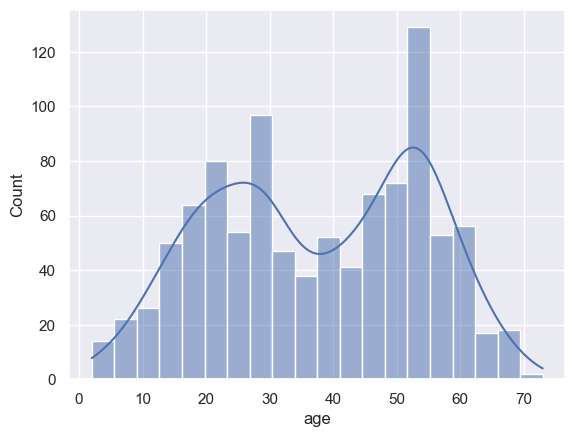

In [9]:
sns.set()
sns.histplot(df['age'], bins=20, kde=True)

### Score Date
Score date is a single date that represents when this flu risk score was generated. Though not set up for this it allows the generation okay timeseries data set that can be run over a period of time showing seasonal change.

In [10]:
# add todays timestamp
df['score_date'] = builder.tools.get_datetime(start=-14, until=-13, size=sample_size, date_format="%Y-%m-%d", ignore_time=True, column_name='score_date')
builder.add_column_description(column_name='score_date', description="The date of the flu risk score")

### Creating Healthcare 


These a latent columns to help in adjusting the distribution of the risk score from its norm.

In [11]:
# member health plan
df['member_health_plan'] = tools.get_category(selection=['PPO', 'HMO'], relative_freq=[6, 4], size=sample_size, column_name='member_health_plan')
builder.add_column_description(column_name='member_health_plan', description="The member health plan")

In [12]:
# healthcare segment 
segment = ["Local Group", "National Accounts", "Medicaid", "BlueCard", "FEP", "Individual"]
df['segment'] = tools.get_category(selection=segment, relative_freq=[38, 19, 18, 15, 4, 2], size=sample_size, column_name='segment', intent_order=0)
builder.add_column_description(column_name='segment', description="The heathcare segment of the member with bias weighting")

In [13]:
# Adjust age for medicare being over 65
selection = [builder.tools.select2dict(column='age', condition='@ >= 65')]

action = tools.action2dict(method='get_category', selection=['Medicare', "Local Group", "National Accounts", "Medicaid"], relative_freq=[99, 0.8, 0.1, 0.1])
default = tools.action2dict(method='@header', header='segment')

df['segment'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='segment', intent_order=1)

In [14]:
# line of buisness
correlations = [["Medicaid", "Medicare"]]
actions = {0: tools.action2dict(method='@constant', value='Business')}

df['line_of_business'] = tools.correlate_categories(df, header='segment', correlations=correlations, actions=actions, default_action='Commercial', column_name='line_of_business')
builder.add_column_description(column_name='line_of_business', description="The line of business this segment is in")

### Creating the Score Social Bias
Latent column to mimic age privilage. Again simplified for demo purposes.

In [15]:
# conditional latent privilage for age under 40
selection = [builder.tools.select2dict(column='age', condition='@<=40')]

action = builder.tools.action2dict(method='get_number', from_value=-0.1, to_value=0.1, precision=1, relative_freq=[20, 1])
default = builder.tools.action2dict(method='get_number', from_value=-0.1, to_value=0.2, precision=1, relative_freq=[3, 20, 1])

df['age_privilege'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age_privilege', intent_order=-1)
builder.add_column_description(column_name='age_privilege', description="set privilege for under 40 with reduced risk with default zero privilage")

In [16]:
# conditional latent privilage for age over 75
selection = [builder.tools.select2dict(column='age', condition='@>75')]

action = builder.tools.action2dict(method='get_number', from_value=-0.1, to_value=0.3, precision=1, relative_freq=[1, 99, 10])
default = builder.tools.action2dict(method='@header', header='age_privilege')

df['age_privilege'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age_privilege', intent_order=-1)
builder.add_column_description(column_name='age_privilege', description="set zero privilage for most over 75")

### Flu Vaccine Segment

In [17]:
# Flu vaccine ICD
df['ins_icd_10_code'] = tools.get_category(selection=['Z23', 'Z28', '0'], relative_freq=[4.5, 1.5, 4], size=sample_size, column_name='ins_icd_10_code', intent_order=0)
builder.add_column_description(column_name='ins_icd_10_code', description="The ICD codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine")

In [18]:
# adjust flu shot for over 65
selection = [builder.tools.select2dict(column='age', condition='@>=65')]

action = builder.tools.action2dict(method='get_category', selection=['Z23', 'Z28', '0'], relative_freq=[6.5, 1, 2.5])
default = builder.tools.action2dict(method='@header', header='ins_icd_10_code')

df['ins_icd_10_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_icd_10_code', intent_order=1)

In [19]:
# adjust flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<=49')]

action = builder.tools.action2dict(method='get_category', selection=['Z23', 'Z28', '0'], relative_freq=[3, 1, 6])
default = builder.tools.action2dict(method='@header', header='ins_icd_10_code')

df['ins_icd_10_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_icd_10_code', intent_order=2)

In [20]:
# Flu vaccine CPT
df['ins_cpt_code'] = tools.get_category(selection=['90674', '90682', '90686', '90688', '90694', '90756'], relative_freq=[13, 7, 1, 0.5, 0.1, 0.01], size=sample_size, column_name='ins_cpt_code', intent_order=0)
builder.add_column_description(column_name='ins_cpt_code', description="The CPT codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine")

In [21]:
# adjust flu shot for over 75
selection = [builder.tools.select2dict(column='age', condition='@>=65')]

action = builder.tools.action2dict(method='get_category', selection=['90653', '90662'], relative_freq=[13, 7])
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=1)

In [22]:
# adjust previous flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<=49')]

action = builder.tools.action2dict(method='get_category', selection=['90672', '90674', '90682', '90686'], relative_freq=[13, 7, 3, 1])
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=2)

In [23]:
# Those on Medicare should have a specific code
selection = [builder.tools.select2dict(column='segment', condition="@=='Medicare'"),
            builder.tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'", logic='AND')]

action = builder.tools.action2dict(method='@constant', value='G0008')
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=3)

In [24]:
# those with no ICD code should have no CPT
selection = [builder.tools.select2dict(column='ins_icd_10_code', condition="@!='Z23'")]

action = builder.tools.action2dict(method='@constant', value='0')
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=4)

In [25]:
# add a date in if ICD is Z23
selection = [builder.tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'")]

action = builder.tools.action2dict(method='get_datetime', start=-380, until=-180, relative_freq=[20, 10, 5, 1], ignore_time=True, date_format='%Y-%m-%d')
default = builder.tools.action2dict(method='@constant', value='')

df['ins_cpt_dt'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_dt')
builder.add_column_description(column_name='ins_cpt_dt', description="if had a previous flu shot, a date between 300 and 600 days previous to today")


### Create the risk score normal distribution

With this and the following sections we are using our satistics to adjust a normal distribution. The key thing to note is that it is a step by step process where each element in itself is straightforward but combined can become powerful. 

In [26]:
df['flu_risk_score'] = builder.tools.get_dist_bounded_normal(mean=0.55, std=0.2, lower=0.1, upper=1, precision=3, size=sample_size, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="A generated flu risk score with a bound normal distribution wth a mean of 0.55 and std of 0.2")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Count'>

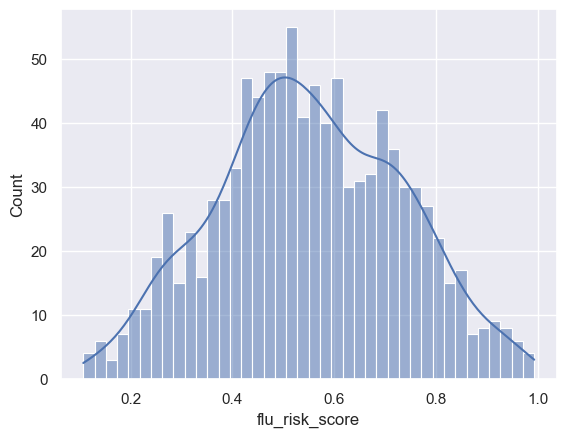

In [27]:
sns.set()
sns.histplot(df['flu_risk_score'], bins=40, kde=True)

### Resample Normal Distribution for those with previous flu shots under 40

In [28]:
# had flu shot so low risk
selection = [tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'"),
             tools.select2dict(column='age', condition='@<40', logic='AND')]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.1, std=0.1, lower=0.001, upper=0.4, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot and under 40 with a bound normal distribution, mean of 0.1 and std of 0.1 with an upper bound of 0.4")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Count'>

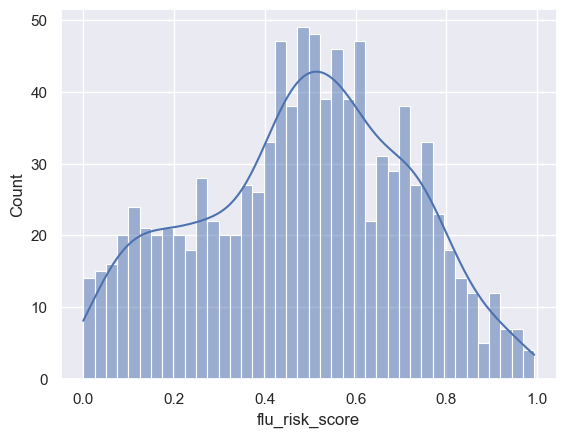

In [29]:
sns.set()
sns.histplot(df['flu_risk_score'], bins=40, kde=True)

### Resample Normal Distribution for those with previous flu shots 40 to under 65

In [30]:
# had flu shot so low risk
selection = [tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'"),
             tools.select2dict(column='age', condition='@>=40', logic='AND'),
             tools.select2dict(column='age', condition='@<65', logic='AND')]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.25, std=0.1, lower=0.001, upper=0.6, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot and 40 <= age < 65, with a bound normal distribution, mean of 0.25 and std of 0.1 with an upper bound of 0.6")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Count'>

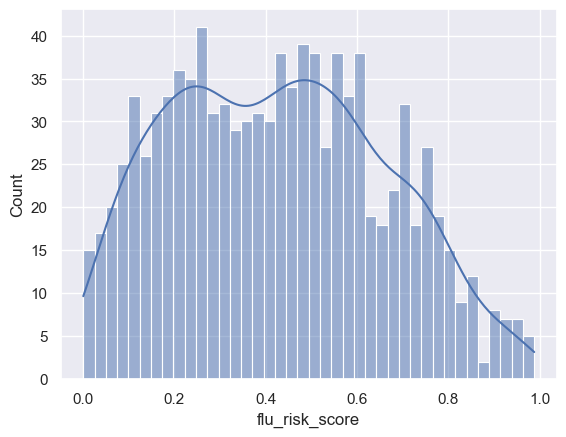

In [31]:
sns.set()
sns.histplot(df['flu_risk_score'], bins=40, kde=True)

### Resample Normal Distribution for those with previous flu shots 65+

In [32]:
# had flu shot so low risk
selection = [tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'"),
             tools.select2dict(column='age', condition='@>=65', logic='AND')]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.4, std=0.15, lower=0.1, upper=0.9, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="normally distribute those with a flue-shot and 65 + with a bound normal distribution, mean of 0.4 and std of 0.15 with an upper bound of 0.9")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Count'>

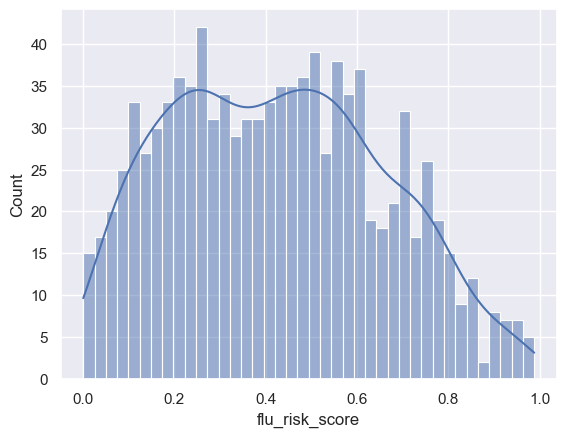

In [33]:
sns.set()
sns.histplot(df['flu_risk_score'], bins=40, kde=True)

### Adjust risk based on the Latent age privilage

In [34]:
# adjust flu risk according to age privilage
selection = [tools.select2dict(column='flu_risk_score', condition="@>0.1"),
             tools.select2dict(column='age', condition="@>40", logic='OR')]

action = tools.action2dict(method='correlate_aggregate', headers=['flu_risk_score', 'age_privilege'], agg='sum', precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='flu_risk_score', intent_order=-1)
builder.add_column_description(column_name='flu_risk_score', description="add age_privilege to the risk score to adjust for the privilage of age")

<AxesSubplot:xlabel='flu_risk_score', ylabel='Count'>

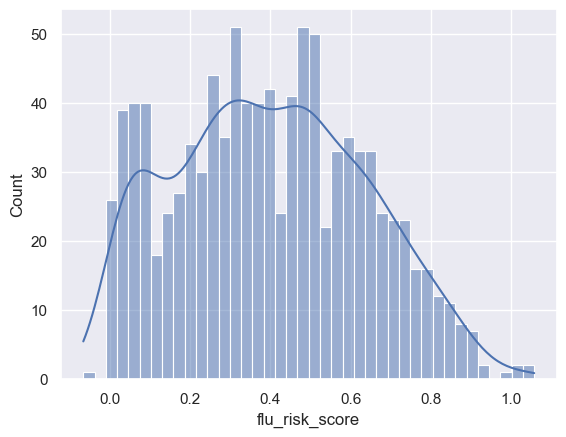

In [35]:
sns.set()
sns.histplot(df['flu_risk_score'], bins=40, kde=True)

In [36]:
# adjust for the upper bound range
selection = [tools.select2dict(column='flu_risk_score', condition="@>=1")]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.9, std=0.02, lower=0.8, upper=0.998, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default , column_name='flu_risk_score', intent_order=-1)

In [37]:
# adjust for the lower bound range
selection = [tools.select2dict(column='flu_risk_score', condition="@<=0")]

action = tools.action2dict(method='get_dist_bounded_normal', mean=0.1, std=0.02, lower=0.01, upper=0.2, precision=3)
default = tools.action2dict(method='@header', header='flu_risk_score')

df['flu_risk_score'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default , column_name='flu_risk_score', intent_order=-1)

<AxesSubplot:xlabel='flu_risk_score', ylabel='Count'>

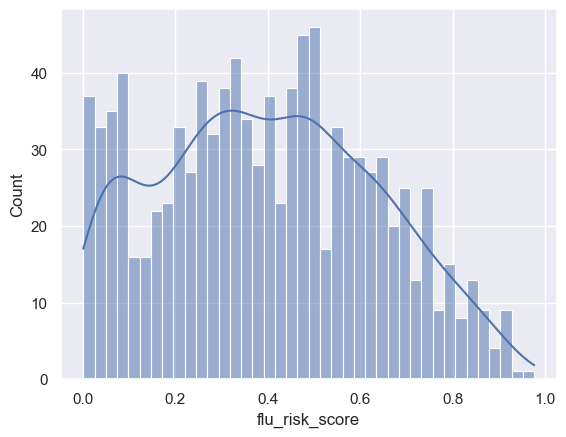

In [38]:
sns.set()
sns.histplot(df['flu_risk_score'], bins=40, kde=True)

### Extract the flu risk score distribution

In [39]:
df = tools.frame_selection(df, headers=['member_id', 'flu_risk_score', 'score_date'], column_name='select_features')

## Run Componant
To run a component we use the common method `run_component_pipeline` which loads the source data, executes the component task , in this case components intent, then persists the results. This is the only method you can use to run the tasks of a component and produce its results and should be a familiarized method.

In [40]:
builder.run_component_pipeline(size=sample_size)

### Report Descriptions

In [41]:
builder.report_column_catalog()

,column_name,description
0,age,An age distribution based on members birth dates
1,age_privilege,"set privilege for under 40 with reduced risk with default zero privilage, set zero privilage for most over 75"
2,flu_risk_score,"A generated flu risk score with a bound normal distribution wth a mean of 0.55 and std of 0.2, normally distribute those with a flue-shot and under 40 with a bound normal distribution, mean of 0.1 and std of 0.1 with an upper bound of 0.4, normally distribute those with a flue-shot and 40 <= age < 65, with a bound normal distribution, mean of 0.25 and std of 0.1 with an upper bound of 0.6, normally distribute those with a flue-shot and 65 + with a bound normal distribution, mean of 0.4 and std of 0.15 with an upper bound of 0.9, add age_privilege to the risk score to adjust for the privilage of age"
3,ins_cpt_code,"The CPT codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine"
4,ins_cpt_dt,"if had a previous flu shot, a date between 300 and 600 days previous to today"
5,ins_icd_10_code,"The ICD codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine"
6,line_of_business,The line of business this segment is in
7,mbr_birth_dt,A distribution of the members date of birth
8,member_health_plan,The member health plan
9,member_id,a unique id for the member


## Report Flu Risk Score

In [42]:
builder.canonical_report(df, stylise=False)

,Attributes (3),dType,%_Null,%_Dom,Count,Unique,Observations
0,flu_risk_score,float64,0.0,0.006,1000,577,"max=0.976 | min=0.001 | mean=0.4 | dominant=[0.091, 0.33]"
1,member_id,object,0.0,0.001,1000,1000,Sample: 21173800411354 | 21180412171354 | 21172636011354 | 21180247211354 | 21174040891354
2,score_date,object,0.0,1.000,1000,1,Sample: 2022-11-08


In [43]:
df.head()

,member_id,score_date,flu_risk_score
0,21173800411354,2022-11-08,0.273
1,21173039091354,2022-11-08,0.590
2,21180205911354,2022-11-08,0.082
3,21173635451354,2022-11-08,0.084
4,21172109151354,2022-11-08,0.271
